In [1]:
# --- 1. O BÁSICO (Pandas, OS, Texto) ---
import pandas as pd
import numpy as np
import os
import re
import glob
import warnings # Pra calar os warnings chatos

# --- 2. GRÁFICOS (Seaborn/Matplotlib) ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. PREPARAÇÃO (SKLEARN) ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# --- 4. OS MODELOS (SKLEARN) ---
from sklearn.linear_model import LogisticRegression  # Modelo 1 (Obrigatório)
from sklearn.naive_bayes import MultinomialNB      # Modelo 2 (Obrigatório)
from sklearn.svm import LinearSVC                  # Modelo 3 (Extra da Etapa 4)

# --- 5. MÉTRICAS E AVALIAÇÃO (SKLEARN) ---
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
from sklearn.model_selection import cross_val_score   # Pra Validação Cruzada (Etapa 4)
from sklearn.model_selection import learning_curve  # Pra Curva de Aprendizado (Etapa 4)

# --- 6. UTILITIES (Pipeline e Colab) ---
from sklearn.pipeline import Pipeline # Pra empacotar tudo (Etapa 4)
from google.colab import drive      # Pro Colab achar o Drive

# --- Config. extra (deixar estilizado) ---
sns.set_style('whitegrid') # Estilo dos gráficos
warnings.filterwarnings('ignore') # Ignorar alguns avisos

print("Todos os pacotes do TCC foram carregados.")

Todos os pacotes do TCC foram carregados.


In [2]:
#Versões Atuais das Bibliotecas Instaladas
!pip freeze | grep -E "pandas|scikit-learn|matplotlib|seaborn|nltk|wordcloud"

geopandas==1.1.1
matplotlib==3.10.0
matplotlib-inline==0.2.1
matplotlib-venn==1.1.2
nltk==3.9.1
pandas==2.2.2
pandas-datareader==0.10.0
pandas-gbq==0.30.0
pandas-stubs==2.2.2.240909
scikit-learn==1.6.1
seaborn==0.13.2
sklearn-pandas==2.2.0
wordcloud==1.9.4


In [3]:
#Permissão para o Colab acessar os arquivos do Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Caminho dos dados
%cd "/content/drive/MyDrive/UTFPR/8º Semestre/TCC2/TCC-2/data"

# Confirme que você está no lugar certo (deve listar seus 9 CSVs + metadata)
!ls

/content/drive/MyDrive/UTFPR/8º Semestre/TCC2/TCC-2/data
dataset_completo.csv	negative_gpt_01.csv    positive_claude_01.csv
metadata.csv		neutral_claude_01.csv  positive_gemini_01.csv
negative_claude_01.csv	neutral_gemini_01.csv  positive_gpt_01.csv
negative_gemini_01.csv	neutral_gpt_01.csv     synthetic_dataset.csv


In [5]:
#UNIFICAÇÃO DOS 9 ARQUIVOS

print("--- Iniciando script de unificação ---")

# 1. Encontrar todos os arquivos CSV, menos o metadata E O DATASET ANTIGO
try:
    arquivos_csv = glob.glob('*.csv')

    if 'metadata.csv' in arquivos_csv:
        arquivos_csv.remove('metadata.csv')
    if 'dataset_completo.csv' in arquivos_csv:
        arquivos_csv.remove('dataset_completo.csv')
    if 'synthetic_dataset.csv' in arquivos_csv: # ignorar o synthetic_data.csv de execuções anteriores
        arquivos_csv.remove('synthetic_dataset.csv')

except ValueError:
    print("Aviso: Falha ao remover arquivos, processando todos os CSVs.")

print(f"Arquivos encontrados para unificação: {arquivos_csv}")

lista_dataframes = []

# 2. Loop para ler cada arquivo e processá-lo
for arquivo in arquivos_csv:
    try:
        # --- CORREÇÃO PRINCIPAL AQUI ---
        # Força a leitura APENAS da primeira coluna (usecols=[0])
        # Isso resolve o bug do 'neutral_gpt_01.csv' que lia a frase como índice
        df_temp = pd.read_csv(
            arquivo,
            header=None,
            names=['frase'],
            usecols=[0] # Força o Pandas a ler SÓ a primeira coluna
        )

        # --- LIMPEZA ROBUSTA (MANTIDA) ---

        # 1. Remove linhas verdadeiramente em branco (NaN)
        df_temp = df_temp.dropna(subset=['frase'])

        # 2. Remove linhas que são "textos vazios" (ex: "") ou só espaços
        df_temp['frase'] = df_temp['frase'].astype(str)
        df_temp = df_temp[df_temp['frase'].str.strip() != ""]

        # --- FIM DAS LINHAS DE CORREÇÃO ---

        nome_arquivo = arquivo.split('.')[0] # Ex: "positive_gemini_01"

        # Adiciona a coluna 'classe'
        if 'positive' in nome_arquivo:
            df_temp['classe'] = 'Positiva'
        elif 'negative' in nome_arquivo:
            df_temp['classe'] = 'Negativa'
        elif 'neutral' in nome_arquivo:
            df_temp['classe'] = 'Neutra'
        else:
            df_temp['classe'] = 'Desconhecida'

        # Adiciona a coluna 'fonte'
        if '_gemini_' in nome_arquivo:
            df_temp['fonte'] = 'Gemini'
        elif '_gpt_' in nome_arquivo:
            df_temp['fonte'] = 'ChatGPT'
        elif '_claude_' in nome_arquivo:
            df_temp['fonte'] = 'Claude'
        else:
            df_temp['fonte'] = 'Desconhecida'

        lista_dataframes.append(df_temp)

    except pd.errors.EmptyDataError:
        print(f"AVISO: O arquivo {arquivo} está vazio e será ignorado.")
    except Exception as e:
        print(f"Erro ao ler o arquivo {arquivo}: {e}")

# 3. Combinar tudo
df_final = pd.concat(lista_dataframes, ignore_index=True)

# 4. Embaralhar
df_final = df_final.sample(frac=1).reset_index(drop=True)

# 5. Salvar
df_final.to_csv('dataset_completo.csv', index=False)

# 6. Mostrar resumo
print("\n--- Processamento Concluído! ---")
print(f"Total de frases no dataset final: {len(df_final)}")
print("\nDistribuição por Classe:")
print(df_final['classe'].value_counts())
print("\nDistribuição por Fonte (IA):")
print(df_final['fonte'].value_counts())
print("\n10 primeiras linhas do dataset:")
print(df_final.head(10))

--- Iniciando script de unificação ---
Arquivos encontrados para unificação: ['positive_gemini_01.csv', 'negative_gemini_01.csv', 'neutral_gemini_01.csv', 'positive_gpt_01.csv', 'negative_gpt_01.csv', 'positive_claude_01.csv', 'negative_claude_01.csv', 'neutral_claude_01.csv', 'neutral_gpt_01.csv']

--- Processamento Concluído! ---
Total de frases no dataset final: 1800

Distribuição por Classe:
classe
Negativa    600
Positiva    600
Neutra      600
Name: count, dtype: int64

Distribuição por Fonte (IA):
fonte
ChatGPT    600
Gemini     600
Claude     600
Name: count, dtype: int64

10 primeiras linhas do dataset:
                                               frase    classe    fonte
0            A produção parece barata e mal cuidada.  Negativa  ChatGPT
1  A história não tinha foco e pulava entre ideia...  Negativa   Gemini
2  Que final espetacular! Superou todas as minhas...  Positiva   Gemini
3        As atuações são exageradas e pouco críveis.  Negativa  ChatGPT
4  A performance do 

In [6]:
#PRÉ PROCESSAMENTO (LIMPEZA)

print("--- Iniciando Etapa de Pré-processamento ---")

# 1. Carregar o dataset unificado que acabamos de criar
try:
    df = pd.read_csv('dataset_completo.csv')
    print(f"Dataset 'dataset_completo.csv' carregado. Total de {len(df)} linhas.")
except FileNotFoundError:
    print("ERRO: Arquivo 'dataset_completo.csv' não encontrado!")
    # Você pode parar o script aqui se preferir
    # raise

# 2. Verificação inicial (pré-limpeza)
print(f"Frases duplicadas encontradas (antes da limpeza): {df.duplicated(subset=['frase']).sum()}")

# 3. Função de Limpeza de Texto
def limpar_texto(texto):
    # Converte tudo para minúsculas
    texto = texto.lower()

    # Remove pontuação, números e caracteres especiais
    # Mantém apenas letras, espaços e acentos
    texto = re.sub(r'[^a-zÀ-ÿ\s]', '', texto)

    # Remove espaços extras (ex: "filme   bom" vira "filme bom")
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

# 4. Aplicar a limpeza na coluna 'frase'
print("Aplicando limpeza (minúsculas, remoção de pontuação/números)...")
df['frase_limpa'] = df['frase'].apply(limpar_texto)

# 5. Verificação pós-limpeza
# Remove duplicatas que apareceram *depois* da limpeza
# (ex: "Filme bom." e "filme bom" viram a mesma coisa)
duplicatas_pos_limpeza = df.duplicated(subset=['frase_limpa']).sum()
print(f"Frases duplicadas encontradas (depois da limpeza): {duplicatas_pos_limpeza}")

# Remove efetivamente as duplicatas
df = df.drop_duplicates(subset=['frase_limpa']).reset_index(drop=True)

# 6. Salvar o dataset final e limpo
# Vamos salvar apenas as colunas que importam para o treino
df_final_limpo = df[['frase_limpa', 'classe', 'fonte', 'frase']]
df_final_limpo.to_csv('synthetic_dataset.csv', index=False)

print("\n--- Pré-processamento Concluído! ---")
print(f"Dataset limpo salvo em 'synthetic_dataset.csv'.")
print(f"Total de frases únicas no dataset final: {len(df_final_limpo)}")
print("\n10 primeiras linhas do dataset limpo:")
# Renomeando a coluna original para clareza
print(df_final_limpo.rename(columns={'frase': 'frase_original'}).head(10))

--- Iniciando Etapa de Pré-processamento ---
Dataset 'dataset_completo.csv' carregado. Total de 1800 linhas.
Frases duplicadas encontradas (antes da limpeza): 2
Aplicando limpeza (minúsculas, remoção de pontuação/números)...
Frases duplicadas encontradas (depois da limpeza): 2

--- Pré-processamento Concluído! ---
Dataset limpo salvo em 'synthetic_dataset.csv'.
Total de frases únicas no dataset final: 1798

10 primeiras linhas do dataset limpo:
                                         frase_limpa    classe    fonte  \
0             a produção parece barata e mal cuidada  Negativa  ChatGPT   
1  a história não tinha foco e pulava entre ideia...  Negativa   Gemini   
2  que final espetacular superou todas as minhas ...  Positiva   Gemini   
3         as atuações são exageradas e pouco críveis  Negativa  ChatGPT   
4  a performance do elenco infantil era particula...  Negativa   Gemini   
5  as emoções foram trabalhadas com muita delicadeza  Positiva  ChatGPT   
6  a série despertou emoçõ

--- Iniciando Etapa de Análise Estatística (com Violin Plot) ---
Dataset 'synthetic_dataset.csv' carregado. Total de 1798 frases.

--- ESTATÍSTICAS GERAIS DO DATASET ---
Número total de frases (amostras): 1798

--- Distribuição por Classe ---
classe
Positiva    600
Neutra      600
Negativa    598
Name: count, dtype: int64

--- Distribuição por Fonte (IA) ---
fonte
Gemini     600
Claude     600
ChatGPT    598
Name: count, dtype: int64

--- Estatísticas do Comprimento das Frases (Nº de Palavras) ---
Média de palavras por frase: 10.56
Mediana de palavras por frase: 10.0
Frase mais curta (palavras): 5
Frase mais longa (palavras): 17

Salvando gráficos na pasta 'results/'...
Gráfico 'distribuicao_classe_por_fonte.png' salvo.
Gráfico 'violino_comprimento_por_fonte.png' salvo.
Gráfico 'distribuicao_comprimento_frases.png' salvo.

--- Análise Estatística Concluída! ---


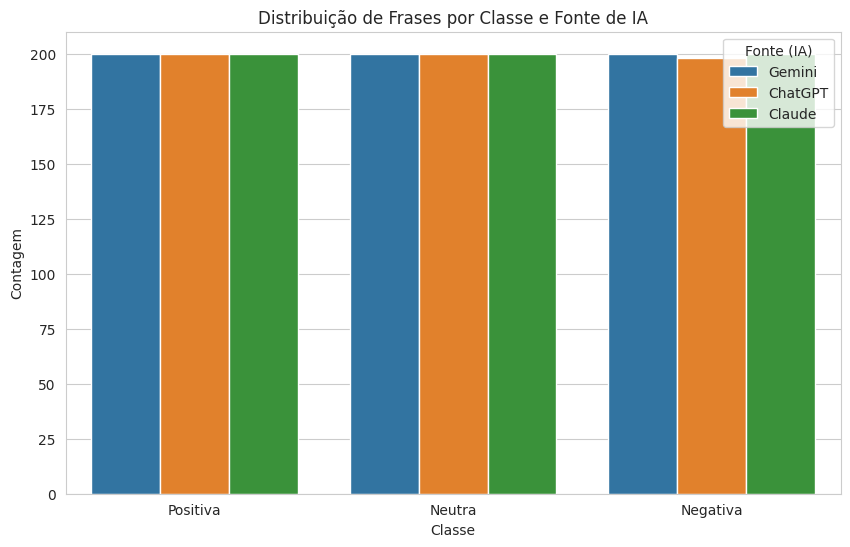

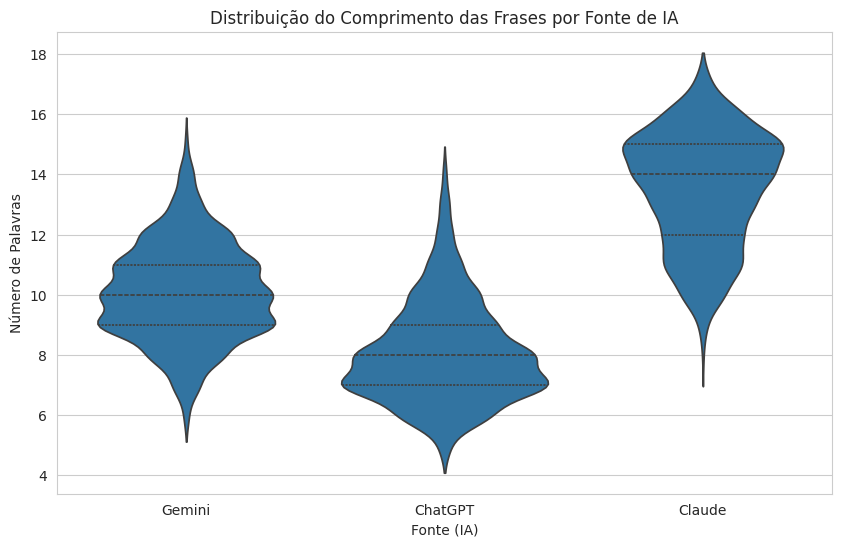

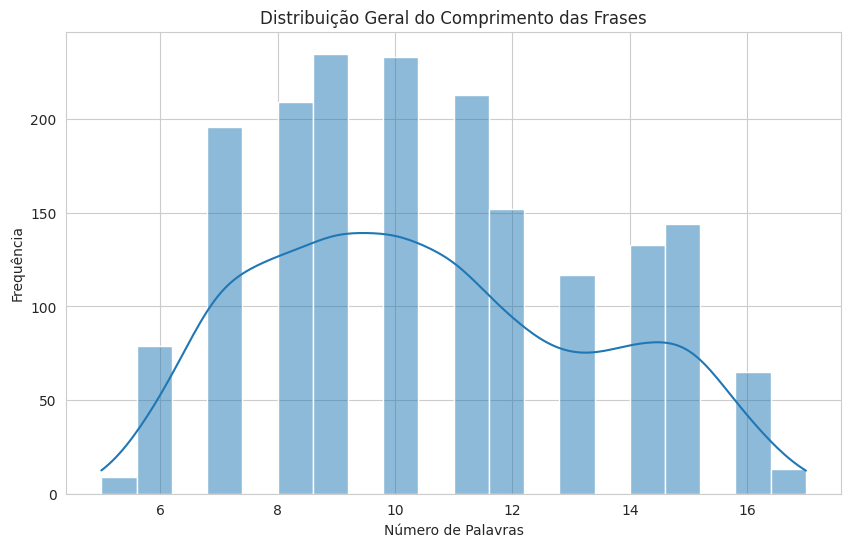

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Iniciando Etapa de Análise Estatística (com Violin Plot) ---")

# 1. Carregar o dataset limpo
try:
    df = pd.read_csv('synthetic_dataset.csv')
    print(f"Dataset 'synthetic_dataset.csv' carregado. Total de {len(df)} frases.")
except FileNotFoundError:
    print("ERRO: Arquivo 'synthetic_dataset.csv' não encontrado! Rode a célula anterior primeiro.")
    raise

# 2. Calcular estatísticas de texto
df['num_palavras'] = df['frase_limpa'].apply(lambda x: len(str(x).split()))

# --- EXIBIÇÃO DAS ESTATÍSTICAS (TEXTO) ---
# (Esta parte é a mesma)
print("\n--- ESTATÍSTICAS GERAIS DO DATASET ---")
print(f"Número total de frases (amostras): {len(df)}")
print("\n--- Distribuição por Classe ---")
print(df['classe'].value_counts())
print("\n--- Distribuição por Fonte (IA) ---")
print(df['fonte'].value_counts())
print("\n--- Estatísticas do Comprimento das Frases (Nº de Palavras) ---")
print(f"Média de palavras por frase: {df['num_palavras'].mean():.2f}")
print(f"Mediana de palavras por frase: {df['num_palavras'].median()}")
print(f"Frase mais curta (palavras): {df['num_palavras'].min()}")
print(f"Frase mais longa (palavras): {df['num_palavras'].max()}")

# --- GERAÇÃO DE GRÁFICOS (AVANÇADOS) ---

# Define o caminho para salvar
pasta_resultados = "../results/"
print("\nSalvando gráficos na pasta 'results/'...")

# --- Gráfico 1 (O Combinado): Barras Agrupadas ---
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='classe',
    hue='fonte',
    order=['Positiva', 'Neutra', 'Negativa'],
    hue_order=['Gemini', 'ChatGPT', 'Claude']
)
plt.title('Distribuição de Frases por Classe e Fonte de IA')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.legend(title='Fonte (IA)')
plt.savefig(f"{pasta_resultados}distribuicao_classe_por_fonte.png")
print(f"Gráfico 'distribuicao_classe_por_fonte.png' salvo.")

# --- Gráfico 2 (O "Mais Legal"): VIOLIN PLOT ---
# TROCAMOS sns.boxplot por sns.violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df,
    x='fonte',
    y='num_palavras',
    order=['Gemini', 'ChatGPT', 'Claude'],
    inner='quartile' # Isso desenha os quartis dentro do violino
)
plt.title('Distribuição do Comprimento das Frases por Fonte de IA')
plt.xlabel('Fonte (IA)')
plt.ylabel('Número de Palavras')
plt.savefig(f"{pasta_resultados}violino_comprimento_por_fonte.png")
print(f"Gráfico 'violino_comprimento_por_fonte.png' salvo.")

# --- Gráfico 3 (O Útil): Histograma Geral ---
plt.figure(figsize=(10, 6))
sns.histplot(df['num_palavras'], bins=20, kde=True)
plt.title('Distribuição Geral do Comprimento das Frases')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.savefig(f"{pasta_resultados}distribuicao_comprimento_frases.png")
print(f"Gráfico 'distribuicao_comprimento_frases.png' salvo.")


print("\n--- Análise Estatística Concluída! ---")

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

print("--- Iniciando Etapa 3: Preparação dos Modelos Baseline ---")

# --- [X] Carregar o synthetic_dataset.csv ---
try:
    df = pd.read_csv('synthetic_dataset.csv')
    print(f"Dataset 'synthetic_dataset.csv' carregado com {len(df)} linhas.")
except FileNotFoundError:
    print("ERRO: 'synthetic_dataset.csv' não encontrado! Rode as células anteriores.")
    raise
except Exception as e:
    print(f"Erro ao carregar o CSV: {e}")
    raise

# Garantir que não há nulos na coluna 'frase_limpa' (embora já tenhamos tratado)
df = df.dropna(subset=['frase_limpa'])

# 1. Definir X (features) e y (target)
X = df['frase_limpa']
y = df['classe']

# 2. Definir nossa "semente" (seed) para reprodutibilidade
# Isso é VITAL para o seu TCC. Garante que os resultados sejam sempre os mesmos.
RANDOM_SEED = 42

# --- [X] Dividir os dados em treino (80%) e teste (20%) ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,      # 20% para teste, 80% para treino
    random_state=RANDOM_SEED, # A nossa "semente"
    stratify=y           # Garante que a % de Pos/Neg/Neu seja a mesma no treino e no teste
)

print("\n--- Divisão Treino/Teste Concluída ---")
print(f"Amostras de Treino (X_train): {len(X_train)}")
print(f"Amostras de Teste (X_test):   {len(X_test)}")
print(f"Rótulos de Treino (y_train): {len(y_train)}")
print(f"Rótulos de Teste (y_test):   {len(y_test)}")

# --- [X] Implementar a vetorização com TF-IDF ---
print("\n--- Iniciando Vetorização TF-IDF ---")

# 1. Criar o vetorizador
tfidf_vectorizer = TfidfVectorizer()

# 2. Aprender o vocabulário e transformar os dados de TREINO
# (Ele "aprende" o que é importante com os dados de treino)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# 3. Apenas transformar os dados de TESTE
# (Usamos o vocabulário que ele já aprendeu, sem "espiar" os dados de teste)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Vetorização TF-IDF Concluída.")
print(f"Shape da Matriz TF-IDF de Treino: {X_train_tfidf.shape}")
print(f"Shape da Matriz TF-IDF de Teste:  {X_test_tfidf.shape}")
print(f"Número total de features (palavras únicas): {X_train_tfidf.shape[1]}")

--- Iniciando Etapa 3: Preparação dos Modelos Baseline ---
Dataset 'synthetic_dataset.csv' carregado com 1798 linhas.

--- Divisão Treino/Teste Concluída ---
Amostras de Treino (X_train): 1438
Amostras de Teste (X_test):   360
Rótulos de Treino (y_train): 1438
Rótulos de Teste (y_test):   360

--- Iniciando Vetorização TF-IDF ---
Vetorização TF-IDF Concluída.
Shape da Matriz TF-IDF de Treino: (1438, 3293)
Shape da Matriz TF-IDF de Teste:  (360, 3293)
Número total de features (palavras únicas): 3293


--- Etapa 3.2: Treinamento - Regressão Logística (Análise F1) ---
Treinando o modelo de Regressão Logística...
Treinamento concluído.

--- Relatório de Classificação (Completo) ---
              precision    recall  f1-score   support

    Negativa       0.88      0.84      0.86       120
      Neutra       0.84      0.90      0.87       120
    Positiva       0.86      0.84      0.85       120

    accuracy                           0.86       360
   macro avg       0.86      0.86      0.86       360
weighted avg       0.86      0.86      0.86       360


--- Veredito (O que importa pro TCC) ---
O F1-Score final (ponderado) do modelo foi: 0.8610 (ou 86.10%)
Gráfico 'f1_score_por_classe_lr.png' salvo em ../results/


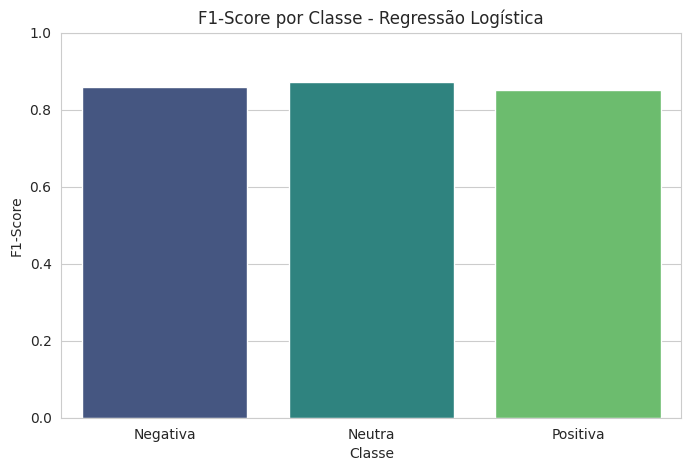


Gerando Matriz de Confusão...
Matriz 'matriz_confusao_lr.png' salva em ../results/


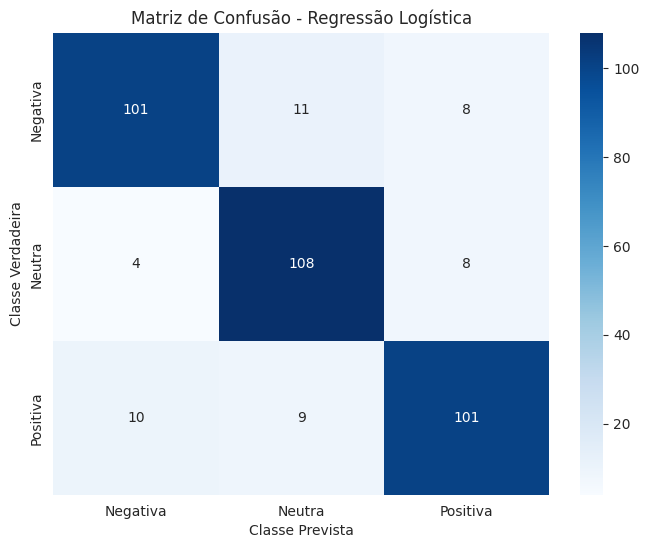


Resultados da Regressão Logística salvos.


In [9]:
print("--- Etapa 3.2: Treinamento - Regressão Logística (Análise F1) ---")

# 1. Inicializar e Treinar o modelo
model_lr = LogisticRegression(random_state=RANDOM_SEED)
print("Treinando o modelo de Regressão Logística...")
model_lr.fit(X_train_tfidf, y_train)
print("Treinamento concluído.")

# 2. Fazer previsões
y_pred_lr = model_lr.predict(X_test_tfidf)

# 3. Gerar Relatório (o "seco")
print("\n--- Relatório de Classificação (Completo) ---")
print(classification_report(y_test, y_pred_lr))

# --- [X] A MÁGICA "EXPLICATIVA" ACONTECE AQUI ---

# 4. Gerar o Relatório como um Dicionário (pra gente poder usar)
report_dict = classification_report(y_test, y_pred_lr, output_dict=True)

# 5. Converter pra um DataFrame do Pandas (pra ficar fácil de mexer)
df_report = pd.DataFrame(report_dict).transpose()

# 6. Pegar só o F1-Score das 3 classes principais
f1_scores = df_report.loc[['Negativa', 'Neutra', 'Positiva'], 'f1-score']

# 7. Imprimir o F1-Score "Ponderado" (A nota final)
f1_final = report_dict['weighted avg']['f1-score']
print(f"\n--- Veredito (O que importa pro TCC) ---")
print(f"O F1-Score final (ponderado) do modelo foi: {f1_final:.4f} (ou {f1_final*100:.2f}%)")

# 8. Plotar o Gráfico de F1-Score por Classe
plt.figure(figsize=(8, 5))
sns.barplot(
    x=f1_scores.index,
    y=f1_scores.values,
    palette='viridis',
    hue=f1_scores.index, # Adiciona cor e legenda
    legend=False # Esconde a legenda duplicada
)
plt.title('F1-Score por Classe - Regressão Logística')
plt.xlabel('Classe')
plt.ylabel('F1-Score')
plt.ylim(0, 1.0) # Força o eixo Y a ir de 0 a 100%

# Salva o gráfico novo
pasta_resultados = "../results/"
plt.savefig(f"{pasta_resultados}f1_score_por_classe_lr.png")
print(f"Gráfico 'f1_score_por_classe_lr.png' salvo em {pasta_resultados}")
plt.show()

# --- CONTINUAÇÃO (Matriz de Confusão e Salvar Métricas) ---

# Gerar Matriz de Confusão
print("\nGerando Matriz de Confusão...")
cm_lr = confusion_matrix(y_test, y_pred_lr)
labels = sorted(y.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.savefig(f"{pasta_resultados}matriz_confusao_lr.png")
print(f"Matriz 'matriz_confusao_lr.png' salva em {pasta_resultados}")
plt.show()

# Armazena os resultados pro nosso dicionário
try:
    resultados_modelos
except NameError:
    resultados_modelos = {}

resultados_modelos['Regressão Logística'] = {
    'Acurácia': report_dict['accuracy'],
    'Precisão': report_dict['weighted avg']['precision'],
    'Recall': report_dict['weighted avg']['recall'],
    'F1-Score': f1_final
}

print("\nResultados da Regressão Logística salvos.")

--- Etapa 3.3: Treinamento - Naive Bayes (Multinomial) ---
Treinando o modelo Naive Bayes...
Treinamento concluído.

--- Relatório de Classificação (Naive Bayes) ---
              precision    recall  f1-score   support

    Negativa       0.86      0.90      0.88       120
      Neutra       0.93      0.89      0.91       120
    Positiva       0.87      0.87      0.87       120

    accuracy                           0.89       360
   macro avg       0.89      0.89      0.89       360
weighted avg       0.89      0.89      0.89       360


--- Veredito (O que importa pro TCC) ---
O F1-Score final (ponderado) do modelo foi: 0.8863 (ou 88.63%)
Gráfico 'f1_score_por_classe_nb.png' salvo em ../results/


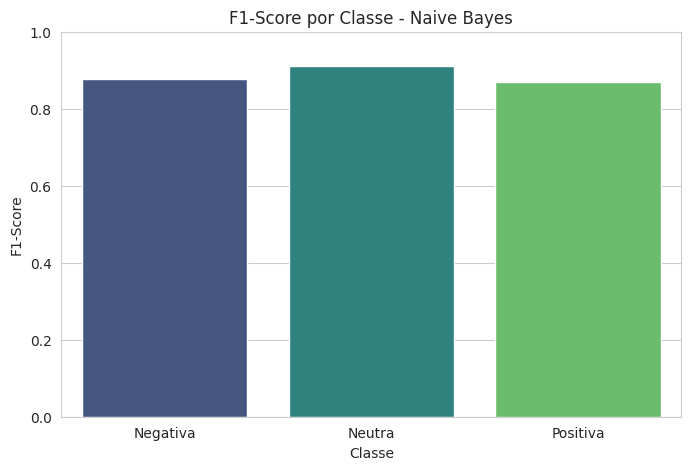


Gerando Matriz de Confusão...
Matriz 'matriz_confusao_nb.png' salva em ../results/


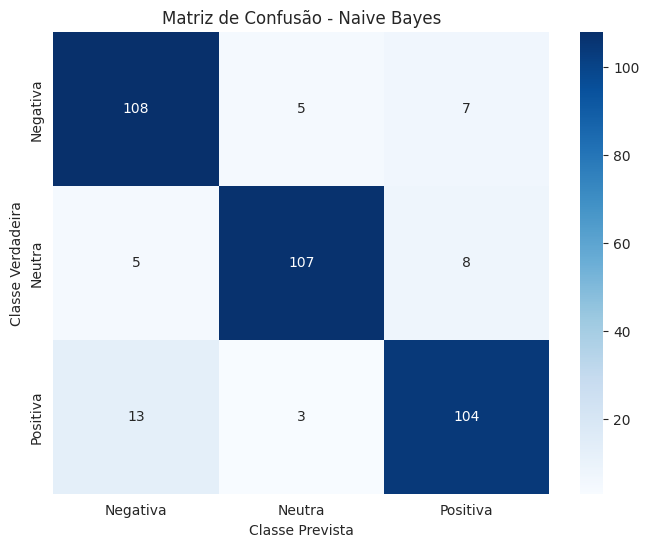


Resultados do Naive Bayes salvos.


In [10]:
print("--- Etapa 3.3: Treinamento - Naive Bayes (Multinomial) ---")

# 1. Inicializar o modelo
model_nb = MultinomialNB()

# 2. Treinar o modelo
print("Treinando o modelo Naive Bayes...")
model_nb.fit(X_train_tfidf, y_train)
print("Treinamento concluído.")

# 3. Fazer previsões
y_pred_nb = model_nb.predict(X_test_tfidf)

# 4. Gerar Relatório (o "seco")
print("\n--- Relatório de Classificação (Naive Bayes) ---")
print(classification_report(y_test, y_pred_nb))

# --- [X] ANÁLISE DO F1-SCORE ---

# 5. Gerar o Relatório como um Dicionário
report_dict_nb = classification_report(y_test, y_pred_nb, output_dict=True)

# 6. Converter pra um DataFrame (só pra pegar o F1)
df_report_nb = pd.DataFrame(report_dict_nb).transpose()

# 7. Pegar só o F1-Score das 3 classes
f1_scores_nb = df_report_nb.loc[['Negativa', 'Neutra', 'Positiva'], 'f1-score']

# 8. Imprimir o Veredito
f1_final_nb = report_dict_nb['weighted avg']['f1-score']
print(f"\n--- Veredito (O que importa pro TCC) ---")
print(f"O F1-Score final (ponderado) do modelo foi: {f1_final_nb:.4f} (ou {f1_final_nb*100:.2f}%)")

# 9. Plotar o Gráfico de F1-Score por Classe
plt.figure(figsize=(8, 5))
sns.barplot(
    x=f1_scores_nb.index,
    y=f1_scores_nb.values,
    palette='viridis',
    hue=f1_scores_nb.index,
    legend=False
)
plt.title('F1-Score por Classe - Naive Bayes')
plt.xlabel('Classe')
plt.ylabel('F1-Score')
plt.ylim(0, 1.0)

# Salva o gráfico novo
pasta_resultados = "../results/"
plt.savefig(f"{pasta_resultados}f1_score_por_classe_nb.png")
print(f"Gráfico 'f1_score_por_classe_nb.png' salvo em {pasta_resultados}")
plt.show()

# --- [X] Matriz de Confusão ---

# 10. Gerar Matriz
print("\nGerando Matriz de Confusão...")
cm_nb = confusion_matrix(y_test, y_pred_nb)
labels = sorted(y.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.title('Matriz de Confusão - Naive Bayes')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.savefig(f"{pasta_resultados}matriz_confusao_nb.png")
print(f"Matriz 'matriz_confusao_nb.png' salva em {pasta_resultados}")
plt.show()

# 11. Armazena os resultados no nosso dicionário
resultados_modelos['Naive Bayes'] = {
    'Acurácia': report_dict_nb['accuracy'],
    'Precisão': report_dict_nb['weighted avg']['precision'],
    'Recall': report_dict_nb['weighted avg']['recall'],
    'F1-Score': f1_final_nb
}

print("\nResultados do Naive Bayes salvos.")

In [12]:
print("--- [X] Relatório Final: Comparativo dos Modelos Baseline ---\n")

# 1. PRINTAR NA TELA (O relatório visual que você já tem)
for nome_modelo, metricas in resultados_modelos.items():
    print(f"--- {nome_modelo} ---")

    # Pega cada métrica, multiplica por 100 e formata com 2 casas
    acc = f"{metricas['Acurácia'] * 100:.2f}%"
    pre = f"{metricas['Precisão'] * 100:.2f}%"
    rec = f"{metricas['Recall'] * 100:.2f}%"
    f1  = f"{metricas['F1-Score'] * 100:.2f}%\n"

    print(f" Acurácia: {acc}")
    print(f" Precisão: {pre}")
    print(f" Recall:   {rec}")
    print(f" F1-Score: {f1}")
    print("--------------------------------------\n")

# 2. SALVAR NO ARQUIVO (A parte nova que faltava)
print("--- Salvando resultados em arquivo... ---")

# Converte o dicionário para um DataFrame do Pandas
df_resultados = pd.DataFrame.from_dict(resultados_modelos, orient='index')

# Arredonda para 4 casas decimais para ficar limpo no CSV
df_resultados = df_resultados.round(4)

# Define o caminho (sobe uma pasta ../ e entra em results/)
caminho_arquivo = "../results/baseline_metrics.csv"

# Salva
try:
    df_resultados.to_csv(caminho_arquivo)
    print(f"✅ Sucesso! Arquivo salvo em: {caminho_arquivo}")
    # Mostra uma prévia do que foi salvo
    print("\nConteúdo salvo no CSV:")
    print(df_resultados)
except Exception as e:
    print(f"❌ Erro ao salvar o arquivo: {e}")

--- [X] Relatório Final: Comparativo dos Modelos Baseline ---

--- Regressão Logística ---
 Acurácia: 86.11%
 Precisão: 86.18%
 Recall:   86.11%
 F1-Score: 86.10%

--------------------------------------

--- Naive Bayes ---
 Acurácia: 88.61%
 Precisão: 88.72%
 Recall:   88.61%
 F1-Score: 88.63%

--------------------------------------

--- Salvando resultados em arquivo... ---
✅ Sucesso! Arquivo salvo em: ../results/baseline_metrics.csv

Conteúdo salvo no CSV:
                     Acurácia  Precisão  Recall  F1-Score
Regressão Logística    0.8611    0.8618  0.8611    0.8610
Naive Bayes            0.8861    0.8872  0.8861    0.8863
